In [2]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm.notebook import tqdm

In [3]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

np.random.seed(0)

cuda:0


In [4]:
# !unzip /content/drive/MyDrive/archive.zip -d .

Streaming output truncated to the last 5000 lines.
  inflating: ./cityscapes_data/cityscapes_data/train/2754.jpg  
  inflating: ./cityscapes_data/cityscapes_data/train/2755.jpg  
  inflating: ./cityscapes_data/cityscapes_data/train/2756.jpg  
  inflating: ./cityscapes_data/cityscapes_data/train/2757.jpg  
  inflating: ./cityscapes_data/cityscapes_data/train/2758.jpg  
  inflating: ./cityscapes_data/cityscapes_data/train/2759.jpg  
  inflating: ./cityscapes_data/cityscapes_data/train/276.jpg  
  inflating: ./cityscapes_data/cityscapes_data/train/2760.jpg  
  inflating: ./cityscapes_data/cityscapes_data/train/2761.jpg  
  inflating: ./cityscapes_data/cityscapes_data/train/2762.jpg  
  inflating: ./cityscapes_data/cityscapes_data/train/2763.jpg  
  inflating: ./cityscapes_data/cityscapes_data/train/2764.jpg  
  inflating: ./cityscapes_data/cityscapes_data/train/2765.jpg  
  inflating: ./cityscapes_data/cityscapes_data/train/2766.jpg  
  inflating: ./cityscapes_data/cityscapes_data/train/2

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# data_dir = os.path.join("/kaggle", "input", "cityscapes-image-pairs", "cityscapes_data")
data_dir = os.path.join("./", "cityscapes_data")
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")

train_fns = os.listdir(train_dir)
val_fns = os.listdir(val_dir)
print(len(train_fns), len(val_fns))

2975 500


./cityscapes_data/train/203.jpg


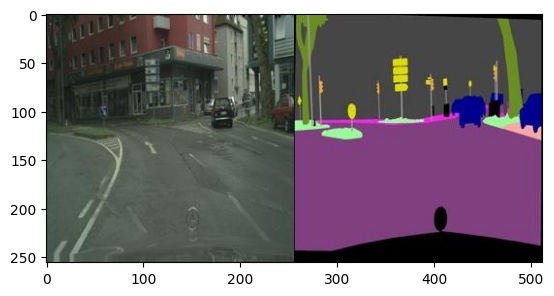

In [6]:
sample_image_fp = os.path.join(train_dir, train_fns[0])
sample_image = Image.open(sample_image_fp).convert("RGB")
plt.imshow(sample_image)
print(sample_image_fp)

In [7]:
def split_image(image):
  image = np.array(image)
  cityscape, label = image[:, :256, :], image[:, 256:, :]
  return cityscape, label

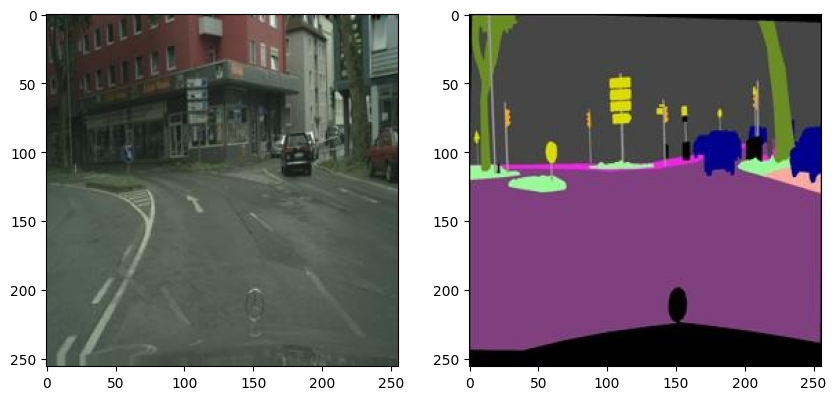

In [8]:
sample_image = np.array(sample_image)
cityscape, label = split_image(sample_image)

# display split images
cityscape, label = Image.fromarray(cityscape), Image.fromarray(label)
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].imshow(cityscape)
axes[1].imshow(label)

In [9]:
num_items = 1000
color_array = np.random.choice(range(256), 3*num_items).reshape(-1,3)
print(color_array.shape)

(1000, 3)


In [10]:
num_classes = 10
label_model = KMeans(n_clusters = num_classes, random_state=60)
label_model.fit(color_array)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=10, random_state=60)

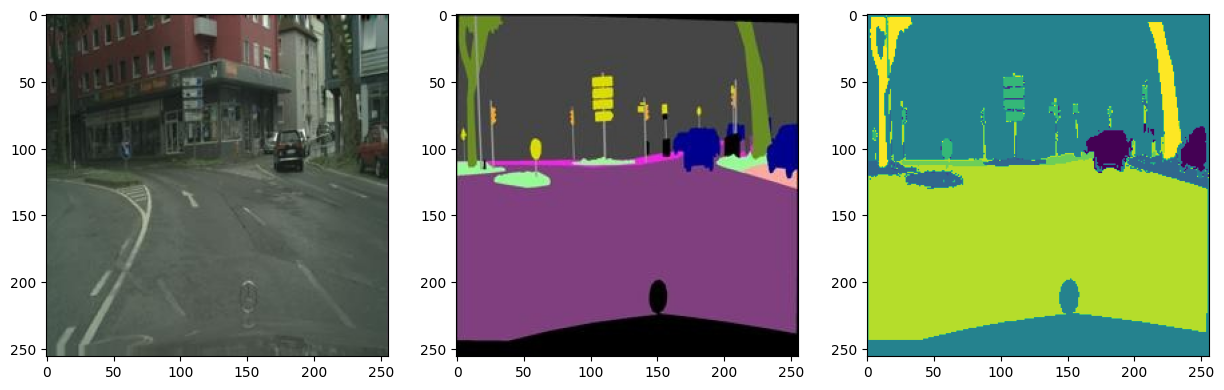

In [11]:
cityscape, label = split_image(sample_image)
label_class = label_model.predict(label.reshape(-1,3)).reshape(256,256)
fig, axes = plt.subplots(1,3,figsize=(15,5))
axes[0].imshow(cityscape)
axes[1].imshow(label)
axes[2].imshow(label_class)

In [12]:
label_class

array([[4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4],
       ...,
       [4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4]], dtype=int32)

In [13]:
class CityscapeDataset(Dataset):

  def __init__(self, image_dir, label_model):
    self.image_dir = image_dir
    self.image_fns = os.listdir(image_dir)
    self.label_model = label_model

  def __len__(self):
    return len(self.image_fns)

  def __getitem__(self, index):
    image_fn = self.image_fns[index]
    image_fp = os.path.join(self.image_dir, image_fn)
    image = Image.open(image_fp).convert("RGB")
    image = np.array(image)
    cityscape, label = self.split_image(image)
    label_class = self.label_model.predict(label.reshape(-1,3)).reshape(256,256)
    label_class = torch.Tensor(label_class).long()
    cityscape = self.transform(cityscape)
    return cityscape, label_class

  def split_image(self, image):
    image = np.array(image)
    cityscape, label = image[:, :256, :], image[:, 256:, :]
    return cityscape, label

  def transform(self, image):
    transform_ops = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=(0.485, 0.56, 0.406), std=(0.229, 0.224, 0.225))
    ])
    return transform_ops(image)

In [14]:
dataset = CityscapeDataset(train_dir, label_model)
print(len(dataset))

2975


In [15]:
cityscape, label_class = dataset[0]
print(cityscape.shape, label_class.shape)

torch.Size([3, 256, 256]) torch.Size([256, 256])


In [16]:
class UNet(nn.Module):

    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=512, out_channels=256)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=128, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)

    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block

    def forward(self, X):
        contracting_11_out = self.contracting_11(X) # [-1, 64, 256, 256]
        contracting_12_out = self.contracting_12(contracting_11_out) # [-1, 64, 128, 128]
        contracting_21_out = self.contracting_21(contracting_12_out) # [-1, 128, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out) # [-1, 128, 64, 64]
        contracting_31_out = self.contracting_31(contracting_22_out) # [-1, 256, 64, 64]
        contracting_32_out = self.contracting_32(contracting_31_out) # [-1, 256, 32, 32]
        contracting_41_out = self.contracting_41(contracting_32_out) # [-1, 512, 32, 32]
        contracting_42_out = self.contracting_42(contracting_41_out) # [-1, 512, 16, 16]
        middle_out = self.middle(contracting_42_out) # [-1, 1024, 16, 16]
        expansive_11_out = self.expansive_11(middle_out) # [-1, 512, 32, 32]
        expansive_12_out = self.expansive_12(torch.cat((expansive_11_out, contracting_41_out), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        expansive_21_out = self.expansive_21(expansive_12_out) # [-1, 256, 64, 64]
        expansive_22_out = self.expansive_22(torch.cat((expansive_21_out, contracting_31_out), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        expansive_31_out = self.expansive_31(expansive_22_out) # [-1, 128, 128, 128]
        expansive_32_out = self.expansive_32(torch.cat((expansive_31_out, contracting_21_out), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        expansive_41_out = self.expansive_41(expansive_32_out) # [-1, 64, 256, 256]
        expansive_42_out = self.expansive_42(torch.cat((expansive_41_out, contracting_11_out), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        output_out = self.output(expansive_42_out) # [-1, num_classes, 256, 256]
        return output_out


class Skipless_UNet(nn.Module):

    def __init__(self, num_classes):
        super(Skipless_UNet, self).__init__()
        self.num_classes = num_classes
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=512, out_channels=512)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=256, out_channels=256)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=128, out_channels=128)
        self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=64, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)

    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block

    def forward(self, X):
        contracting_11_out = self.contracting_11(X) # [-1, 64, 256, 256]
        contracting_12_out = self.contracting_12(contracting_11_out) # [-1, 64, 128, 128]
        contracting_21_out = self.contracting_21(contracting_12_out) # [-1, 128, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out) # [-1, 128, 64, 64]
        contracting_31_out = self.contracting_31(contracting_22_out) # [-1, 256, 64, 64]
        contracting_32_out = self.contracting_32(contracting_31_out) # [-1, 256, 32, 32]
        contracting_41_out = self.contracting_41(contracting_32_out) # [-1, 512, 32, 32]
        contracting_42_out = self.contracting_42(contracting_41_out) # [-1, 512, 16, 16]
        middle_out = self.middle(contracting_42_out) # [-1, 1024, 16, 16]
        expansive_11_out = self.expansive_11(middle_out) # [-1, 512, 32, 32]
        expansive_12_out = self.expansive_12(expansive_11_out) # [-1, 512, 32, 32]
        expansive_21_out = self.expansive_21(expansive_12_out) # [-1, 256, 64, 64]
        expansive_22_out = self.expansive_22(expansive_21_out) # [-1, 256, 64, 64]
        expansive_31_out = self.expansive_31(expansive_22_out) # [-1, 128, 128, 128]
        expansive_32_out = self.expansive_32(expansive_31_out) # [-1, 128, 128, 128]
        expansive_41_out = self.expansive_41(expansive_32_out) # [-1, 64, 256, 256]
        expansive_42_out = self.expansive_42(expansive_41_out) # [-1, 64, 256, 256]
        output_out = self.output(expansive_42_out) # [-1, num_classes, 256, 256]
        return output_out

Do not change above this

In [27]:
# model = UNet(num_classes=num_classes)
model = Skipless_UNet(num_classes=num_classes)

In [28]:
data_loader = DataLoader(dataset, batch_size = 4)
print(len(dataset), len(data_loader))

X, Y = next(iter(data_loader))
print(X.shape, Y.shape)

2975 744
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])


In [29]:
Y_pred = model(X)
print(Y_pred.shape)

torch.Size([4, 10, 256, 256])


In [30]:
batch_size = 16

epochs = 5
lr = 0.01

In [31]:
dataset = CityscapeDataset(train_dir, label_model)
data_loader = DataLoader(dataset, batch_size = batch_size)

In [32]:
# model = UNet(num_classes = num_classes).to(device)
model = Skipless_UNet(num_classes = num_classes).to(device)

In [33]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = lr)

In [34]:
step_losses = []
epoch_losses = []

for epoch in tqdm(range(epochs)):
  epoch_loss = 0
  for X,Y in tqdm(data_loader, total=len(data_loader), leave = False):
    X, Y = X.to(device), Y.to(device)
    optimizer.zero_grad()
    Y_pred = model(X)
    loss = criterion(Y_pred, Y)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    step_losses.append(loss.item())
  epoch_losses.append(epoch_loss/len(data_loader))

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

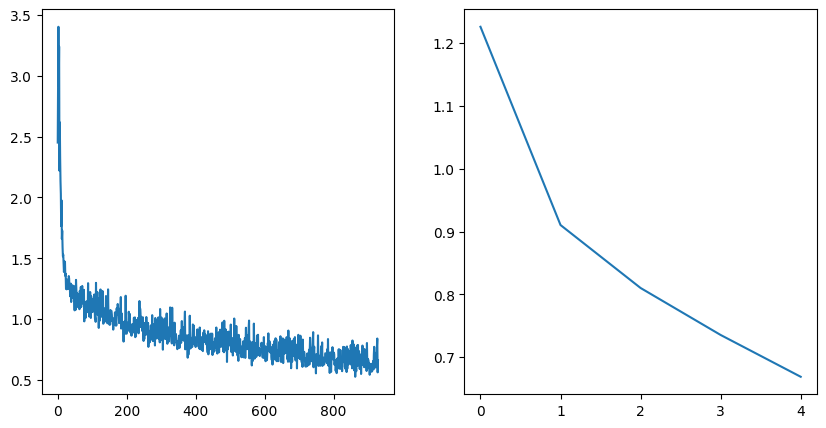

In [35]:
fig, axes = plt.subplots(1,2, figsize=(10,5))
axes[0].plot(step_losses)
axes[1].plot(epoch_losses)

In [36]:
# model_name = "U-Net.pth"
model_name = "U-Net-skipless.pth"
torch.save(model.state_dict(), model_name)

Loading and Testing

In [37]:
model_path = "./U-Net.pth"
model_ = UNet(num_classes=num_classes).to(device)
model_.load_state_dict(torch.load(model_path))

skipless_model_path = "./U-Net-skipless.pth"
skipless_model_ = Skipless_UNet(num_classes=num_classes).to(device)
skipless_model_.load_state_dict(torch.load(skipless_model_path))

<All keys matched successfully>

In [38]:
test_batch_size = 10
dataset = CityscapeDataset(val_dir, label_model)
data_loader = DataLoader(dataset, batch_size=test_batch_size)

In [39]:
X,Y = next(iter(data_loader))
X,Y = X.to(device), Y.to(device)

Y_pred = model_(X)
print(Y_pred.shape)
Y_pred = torch.argmax(Y_pred, dim=1)
print(Y_pred.shape)

Y_pred_skipless = skipless_model_(X)
print(Y_pred_skipless.shape)
Y_pred_skipless = torch.argmax(Y_pred_skipless, dim=1)
print(Y_pred_skipless.shape)

torch.Size([10, 10, 256, 256])
torch.Size([10, 256, 256])
torch.Size([10, 10, 256, 256])
torch.Size([10, 256, 256])


In [40]:
inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])

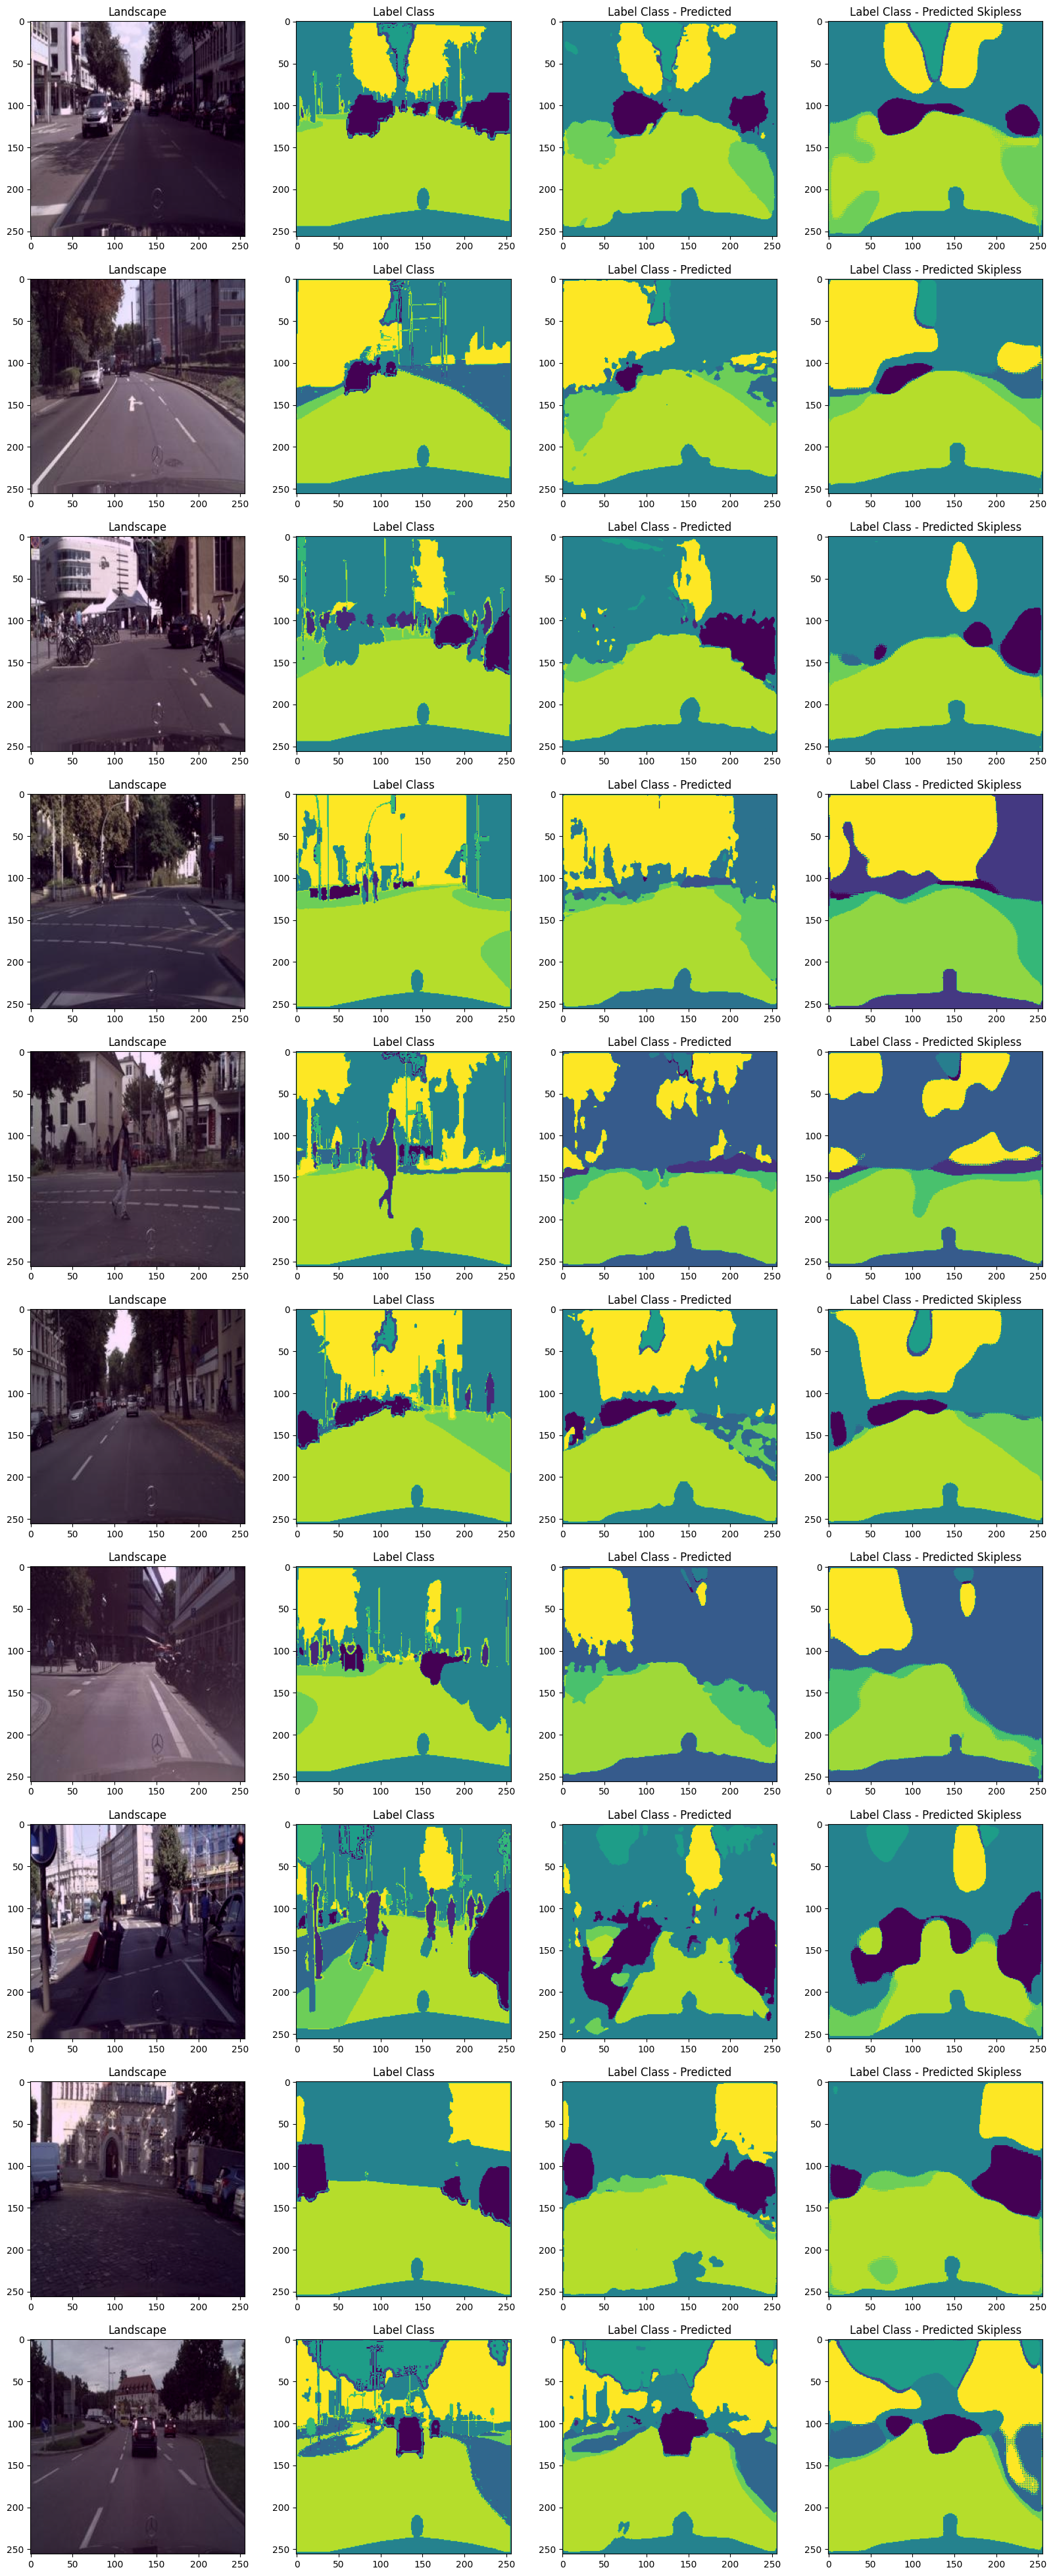

In [46]:
fig, axes = plt.subplots(test_batch_size, 4, figsize=(4*5, test_batch_size*5))

iou_scores = []
iou_scores_skipless = []

for i in range(test_batch_size):

    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()
    label_class_predicted_skipless = Y_pred_skipless[i].cpu().detach().numpy()

    # IOU score
    # intersection = np.logical_and(label_class, label_class_predicted)
    # union = np.logical_or(label_class, label_class_predicted)
    # iou_score = np.sum(intersection) / np.sum(union)
    # iou_scores.append(iou_score)
    iou_score = 0
    for j in range(num_classes):
        intersection = np.logical_and(label_class == j, label_class_predicted == j)
        union = np.logical_or(label_class == j, label_class_predicted == j)
        if np.sum(union) != 0:
          iou_score += np.sum(intersection) / np.sum(union)
    iou_score /= num_classes
    iou_scores.append(iou_score)


    # IOU score skipless
    # intersection = np.logical_and(label_class, label_class_predicted_skipless)
    # union = np.logical_or(label_class, label_class_predicted_skipless)
    # iou_score = np.sum(intersection) / np.sum(union)
    # iou_scores_skipless.append(iou_score)
    iou_score_skipless = 0
    for j in range(num_classes):
        intersection = np.logical_and(label_class == j, label_class_predicted_skipless == j)
        union = np.logical_or(label_class == j, label_class_predicted_skipless == j)
        if np.sum(union) != 0:
          iou_score_skipless += np.sum(intersection) / np.sum(union)
    iou_score_skipless /= num_classes
    iou_scores_skipless.append(iou_score_skipless)

    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class)
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted)
    axes[i, 2].set_title("Label Class - Predicted")
    axes[i, 3].imshow(label_class_predicted_skipless)
    axes[i, 3].set_title("Label Class - Predicted Skipless")

In [47]:
print("Unet IOU Score")
print(sum(iou_scores) / len(iou_scores))

print("Skipless Unet IOU Score")
print(sum(iou_scores_skipless) / len(iou_scores_skipless))

Unet IOU Score
0.3299110563676448
Skipless Unet IOU Score
0.33201961177389194


## 1.2
The results for Unet compared with a skip-connection-less Unet can be seen from the two cells above. Both were run for 5 epochs.
Qualitatively, we see that without skip connections, the model is unable to predict sharp boundaries for the segments. The segments are smooth and do not work well in cases where there are sharp objects. The usual Unet model is able to capture the sharp boundaries as well. This is because skip connections allow the decoder to look at the finer details of the image without having to remember them. This allows for better and sharper segmentation.
Quantitatively, the IOU score (uncorrected) of both models are comparable. This is because even though the sharp boundaries are absent in the second model (without skip connections), the area of predicted segment agrees well with the label. Note that even after correction, we do not observe much difference in the IOU scores of the normal model and the one without skip-connections. But the difference is visible to the naked eye.

## 1.3
The metric is wrong, because logical_and and logical_or just look for 0 or non-zero, instead of verifying if the class is indeed the same. This means that [1, 2, 0, 5] and [2, 0, 5, 5] would be [True, False, False, True] for logical_and, which is not what we want. We want True only if the class number also matches.
This is the additional criterion to be used. So, I rewrote the metric function to instead compute an IoU for each class. The score for each image is the mean over all classes.

The corrected mIOU is not much different between the model with and without skip connections, though the raw score has decreased significantly for both the models (expected). This is due to the fact that IOU is a measure of the amount of area correctly predicted, and does not explicitly care about the shape of the boundaries. So it is possible that the model without skip connections still managed to get a similar score without sharp boundaries because the number of pixels correctly classified is similar, since sharper boundaries require higher precison. As long as the general area of the segment is majorly classified correctly, the IOU score will be high.